# May 20, 2022: Check temporal masking in another dataset
Check in the previous dataset - segment was between block start and shock shart, ... (dataset in April 2, 2022) - if a different mask value would alter model's performance drastically.

`Schaefer 300 ROIs dataset`

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/may22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-05-20 11:46:58.273615: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-20 11:47:00.354853: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-20 11:47:00.391213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 11:47:00.391628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 11:47:00.391674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## emoprox2 full dataset

In [2]:
def get_data_samples(data, subject_list):
    X = [] 
    y = []
    Xlen = [] 
    pos = [] 
    idx = []

    for subject in subject_list:
        X += data[subject][0]
        y += data[subject][1]
        Xlen += [i.shape[0] for i in data[subject][0]]
        pos += data[subject][2]
        idx += data[subject][3]

    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, padding="post",
        dtype='float'
    )

    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y, padding="post",
        dtype='float'
    )

    return X_padded, y_padded, Xlen, pos, idx

In [3]:
hemo_lag = 2
raw_data_file = (f"/home/joyneelm/approach-retreat/near_miss_analysis/classification_data"
                 f"/Schaefer2018_roi300_net17_122subjs_full_segments_withshock_hemodynamic_lag{hemo_lag}.pkl")
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

In [4]:
MASK = 0.0
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

In [5]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train, 
 pos_train, idx_train) = get_data_samples(data, train_list)
(X_test, y_test, 
 len_test, 
 pos_test, idx_test) = get_data_samples(data, test_list)

## train model on dataset with temporal mask `MASK == 0.0`

In [6]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 50
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

In [7]:
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

In [8]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer, 
        mask_value=MASK, 
        return_sequences=True)

    '''
    train model
    '''
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))
    
# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

2022-05-20 11:47:25.431819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 11:47:25.433928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 11:47:25.434459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-05-20 11:47:25.434542: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-20 11:47:25.827338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

Epoch 1/50


2022-05-20 11:47:27.537354: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-20 11:47:27.891579: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


28/28 [==============================] - 10s 286ms/step - loss: 1.8732 - sparse_categorical_accuracy: 0.5001 - val_loss: 1.6496 - val_sparse_categorical_accuracy: 0.5443
Epoch 2/50
28/28 [==============================] - 8s 270ms/step - loss: 1.5171 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.3339 - val_sparse_categorical_accuracy: 0.5771
Epoch 3/50
28/28 [==============================] - 7s 265ms/step - loss: 1.2332 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.0858 - val_sparse_categorical_accuracy: 0.5968
Epoch 4/50
28/28 [==============================] - 8s 270ms/step - loss: 1.0094 - sparse_categorical_accuracy: 0.5551 - val_loss: 0.8914 - val_sparse_categorical_accuracy: 0.6115
Epoch 5/50
28/28 [==============================] - 8s 274ms/step - loss: 0.8346 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.7394 - val_sparse_categorical_accuracy: 0.6265
Epoch 6/50
28/28 [==============================] - 8s 270ms/step - loss: 0.6987 - sparse_categorical_accuracy

2022-05-20 11:53:47.182383: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/emoprox_full_data/models/GRU_classifier_hemolag2_300_mask0.0/assets
70/70 [==============================] - 3s 43ms/step - loss: nan - sparse_categorical_accuracy: 0.6819


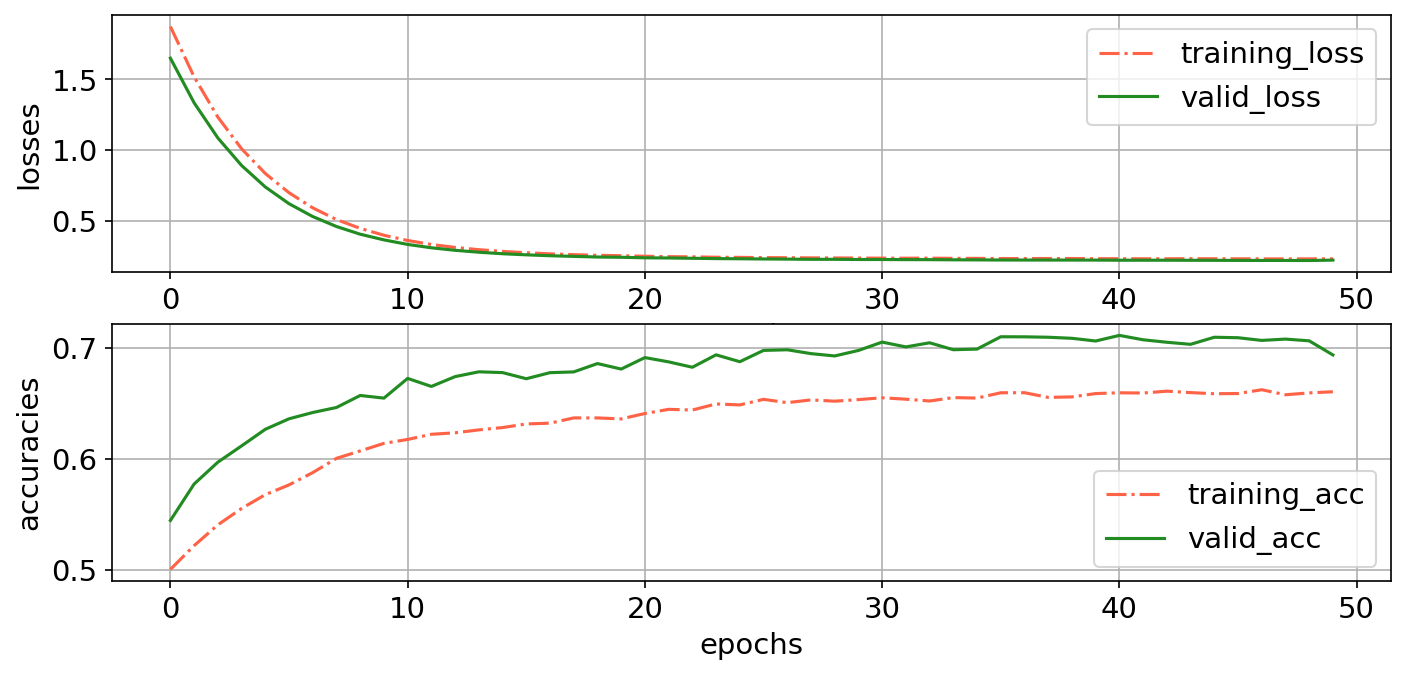

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11,5),
    dpi=150
)

ax = axs[0]
ax.plot(history['loss'], color='tomato', linestyle='-.', label='training_loss')
ax.plot(history['val_loss'], color='forestgreen', label='valid_loss')
ax.set_ylabel(f"losses")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(history['sparse_categorical_accuracy'], color='tomato', linestyle='-.', label='training_acc')
ax.plot(history['val_sparse_categorical_accuracy'], color='forestgreen', label='valid_acc')
ax.set_ylabel(f"accuracies")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

## train model on dataset with temporal mask `MASK == 0.5`.

GRU model's accuracy is 68%. This is more than that on MAX dataset.

Now change the `MASK` value to 0.5 (as in idea1's ipynb's) and observe changes in accuracy.

In [10]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train, 
 pos_train, idx_train) = get_data_samples(data, train_list)
(X_test, y_test, 
 len_test, 
 pos_test, idx_test) = get_data_samples(data, test_list)

In [11]:
OLD_MASK, MASK = 0.0, 0.5
for idx_sample in np.arange(X_train.shape[0]):
    X = X_train[idx_sample:idx_sample+1, :, :]
    y = y_train[idx_sample:idx_sample+1, :]
    mask_times = np.unique(np.where(X == OLD_MASK)[1])
    X[:, mask_times , :] = MASK
    y[:, mask_times] = MASK

for idx_sample in np.arange(X_test.shape[0]):
    X = X_test[idx_sample:idx_sample+1, :, :]
    y = y_test[idx_sample:idx_sample+1, :]
    mask_times = np.unique(np.where(X == OLD_MASK)[1])
    X[:, mask_times , :] = MASK
    y[:, mask_times] = MASK

### no custom loss

In [24]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}_nocustomloss"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}_nocustomloss_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer, 
        mask_value=MASK, 
        return_sequences=True)

    '''
    train model
    '''
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))
    
# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

Epoch 1/50
28/28 [==============================] - 10s 285ms/step - loss: 1.8736 - sparse_categorical_accuracy: 0.4999 - val_loss: 1.6505 - val_sparse_categorical_accuracy: 0.5461
Epoch 2/50
28/28 [==============================] - 8s 271ms/step - loss: 1.5175 - sparse_categorical_accuracy: 0.5213 - val_loss: 1.3348 - val_sparse_categorical_accuracy: 0.5770
Epoch 3/50
28/28 [==============================] - 7s 267ms/step - loss: 1.2347 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.0877 - val_sparse_categorical_accuracy: 0.5952
Epoch 4/50
28/28 [==============================] - 7s 269ms/step - loss: 1.0112 - sparse_categorical_accuracy: 0.5509 - val_loss: 0.8925 - val_sparse_categorical_accuracy: 0.6102
Epoch 5/50
28/28 [==============================] - 7s 265ms/step - loss: 0.8357 - sparse_categorical_accuracy: 0.5659 - val_loss: 0.7399 - val_sparse_categorical_accuracy: 0.6263
Epoch 6/50
28/28 [==============================] - 8s 271ms/step - loss: 0.6988 - sparse_categoric

In [25]:
y_pred = model(X_train)
# print(y_pred[:1, ...])

print(np.argmax(y_pred[:1, ...], axis=-1))
print(y_train[:1, ...])

[[1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5]]


### custom loss

In [18]:
class CustomSCCE(tf.keras.losses.Loss):
    '''
    Custom Sparse Categorical Crossentropy
    '''
    def __init__(self, name='custom_scce'):
        super().__init__(name=name)
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true != MASK, tf.float32)
        loss *= mask
        # average on non-zeros
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [19]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}_customloss"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_300_mask{MASK}_customloss_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer, 
        mask_value=MASK, 
        return_sequences=True)

    '''
    train model
    '''
    model.compile(
        loss=CustomSCCE(), #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))
    
# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

Epoch 1/50
28/28 [==============================] - 10s 290ms/step - loss: 1.8732 - sparse_categorical_accuracy: 0.5032 - val_loss: 1.6510 - val_sparse_categorical_accuracy: 0.5417
Epoch 2/50
28/28 [==============================] - 8s 270ms/step - loss: 1.5166 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.3352 - val_sparse_categorical_accuracy: 0.5745
Epoch 3/50
28/28 [==============================] - 7s 262ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.5382 - val_loss: 1.0876 - val_sparse_categorical_accuracy: 0.5934
Epoch 4/50
28/28 [==============================] - 8s 273ms/step - loss: 1.0111 - sparse_categorical_accuracy: 0.5522 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.6091
Epoch 5/50
28/28 [==============================] - 8s 280ms/step - loss: 0.8356 - sparse_categorical_accuracy: 0.5650 - val_loss: 0.7404 - val_sparse_categorical_accuracy: 0.6231
Epoch 6/50
28/28 [==============================] - 7s 267ms/step - loss: 0.6983 - sparse_categoric

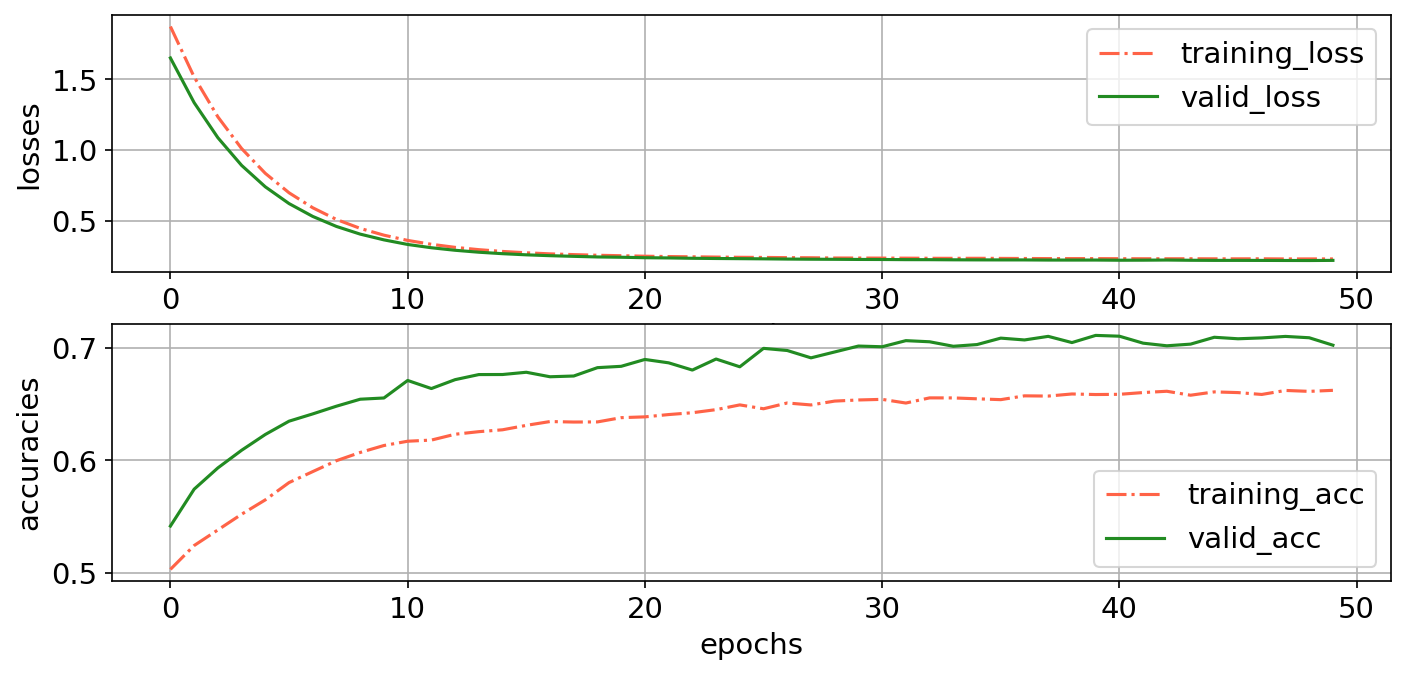

In [20]:
fig, axs = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11,5),
    dpi=150
)

ax = axs[0]
ax.plot(history['loss'], color='tomato', linestyle='-.', label='training_loss')
ax.plot(history['val_loss'], color='forestgreen', label='valid_loss')
ax.set_ylabel(f"losses")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(history['sparse_categorical_accuracy'], color='tomato', linestyle='-.', label='training_acc')
ax.plot(history['val_sparse_categorical_accuracy'], color='forestgreen', label='valid_acc')
ax.set_ylabel(f"accuracies")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

In [22]:
y_pred = model(X_train)
# print(y_pred[:1, ...])

print(np.argmax(y_pred[:1, ...], axis=-1))
print(y_train[:1, ...])

[[1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5]]


Accuracies are around 70%. 
But interestingly, neither MASK nor custom loss affect performance!!

| MASK | Loss | Accuracy |
| :--- | :--- | :---     |
| 0.0  | non  | 68%      |
| 0.5  | non  | 68%      |
| 0.5  | custom | 68%    |